In [1]:
print("Hello world", flush=True)

try:
    get_ipython().run_line_magic("reset", "-f")
except NameError:
    is_notebook = False
    p = print
else:
    is_notebook = True
    p = display
    # p = print

import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

print("Importing torch", flush=True)
import torch
print("torch imported", flush=True)

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

if is_notebook:
    import matplotlib.pyplot as plt
    import seaborn as sns

    pd.set_option("display.expand_frame_repr", False)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)
    plt.rcParams["figure.figsize"] = (10, 2)

Hello world
Importing torch
torch imported


In [2]:
data_dir = f"../datasets/march-machine-learning-mania-2025"

MNCAATourneyDetailedResults     1,382 33 2003 2024
MRegularSeasonDetailedResults 117,748 33 2003 2025
WNCAATourneyDetailedResults       894 33 2010 2024
WRegularSeasonDetailedResults  80,626 33 2010 2025
--------------------------------------------------
detailed_results              200,650 33 2003 2025

['Season', 'TeamID', 'Score', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF']



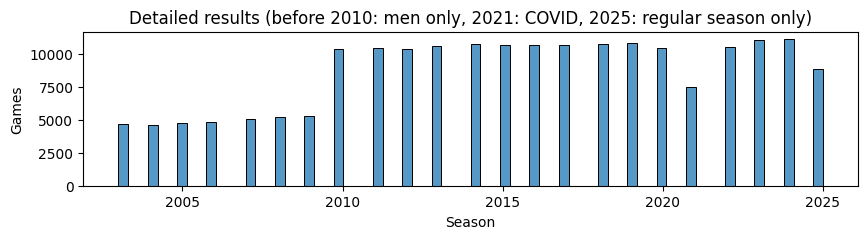

In [3]:
def read_detailed_results(fn):
    df = pd.read_csv(f"{data_dir}/{fn}.csv")
    for c in df.select_dtypes("int64"):
        df[c] = df[c].astype("int32")
    df = df.rename(columns={"Season": "WSeason"})
    df["LSeason"] = df["WSeason"]
    df = df.drop(columns=["NumOT", "WLoc"])
    assert all(df[c].dtype == "int32" for c in df)
    print(
        f"{fn:<29} {df.shape[0]:>7,} {df.shape[1]:>2} {df['WSeason'].min()} {df['WSeason'].max()}"
    )
    return df


MNCAATourneyDetailedResults = read_detailed_results("MNCAATourneyDetailedResults")
MRegularSeasonDetailedResults = read_detailed_results("MRegularSeasonDetailedResults")
WNCAATourneyDetailedResults = read_detailed_results("WNCAATourneyDetailedResults")
WRegularSeasonDetailedResults = read_detailed_results("WRegularSeasonDetailedResults")

detailed_results = pd.concat(
    [
        MNCAATourneyDetailedResults,
        MRegularSeasonDetailedResults,
        WNCAATourneyDetailedResults,
        WRegularSeasonDetailedResults,
    ]
).reset_index(drop=True)

print(
    f"{'-'*50}\n{'detailed_results':<29} {detailed_results.shape[0]:>7,} {detailed_results.shape[1]:>2} {detailed_results['WSeason'].min()} {detailed_results['WSeason'].max()}"
)
assert 1 == len([c for c in detailed_results if c[0] not in ("W", "L")])
print(f"\n{[c[1:] for c in detailed_results if c[0] == 'W']}\n")

if is_notebook:
    sns.histplot(detailed_results["WSeason"])
    plt.title(
        "Detailed results (before 2010: men only, 2021: COVID, 2025: regular season only)"
    )
    plt.xlabel("Season")
    plt.ylabel("Games");

,Season,DayNum,TeamID_1,TeamID_2,Margin
0,2003,134,1411,1421,-8.0
1,2003,136,1112,1436,29.0
2,2003,136,1113,1272,13.0
3,2003,136,1141,1166,6.0
4,2003,136,1143,1301,2.0
...,...,...,...,...,...
200645,2025,106,3242,3416,5.0
200646,2025,106,3329,3428,4.0
200647,2025,106,3194,3349,-33.0
200648,2025,106,3150,3378,-18.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200650 entries, 0 to 200649
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Season    200650 non-null  int32  
 1   DayNum    200650 non-null  int32  
 2   TeamID_1  200650 non-null  int32  
 3   TeamID_2  200650 non-null  int32  
 4   Margin    200650 non-null  float32
dtypes: float32(1), int32(4)
memory usage: 3.8 MB



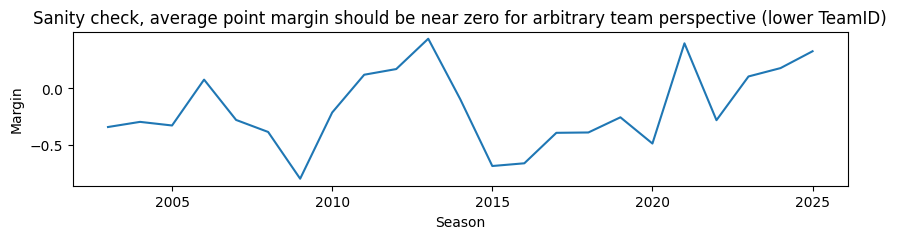

In [4]:
margin = detailed_results[
    ["WSeason", "DayNum", "WTeamID", "LTeamID", "WScore", "LScore"]
]
margin = margin.rename(columns={"WSeason": "Season"})
mask = margin["WTeamID"] < margin["LTeamID"]

margin.loc[mask, ["TeamID_1", "TeamID_2", "Margin"]] = np.column_stack(
    [
        margin.loc[mask, "WTeamID"].values,
        margin.loc[mask, "LTeamID"].values,
        (margin.loc[mask, "WScore"] - margin.loc[mask, "LScore"]).values,
    ]
)

margin.loc[~mask, ["TeamID_1", "TeamID_2", "Margin"]] = np.column_stack(
    [
        margin.loc[~mask, "LTeamID"].values,
        margin.loc[~mask, "WTeamID"].values,
        (margin.loc[~mask, "LScore"] - margin.loc[~mask, "WScore"]).values,
    ]
)

margin["TeamID_1"] = margin["TeamID_1"].astype("int32")
margin["TeamID_2"] = margin["TeamID_2"].astype("int32")
margin["Margin"] = margin["Margin"].astype("float32")
margin = margin.drop(columns=["WTeamID", "LTeamID", "WScore", "LScore"])

p(margin)
margin.info()
print()

if is_notebook:
    sns.lineplot(
        margin.groupby("Season")["Margin"].mean().reset_index(),
        x="Season",
        y="Margin",
    )
    plt.title(
        "Sanity check, average point margin should be near zero for arbitrary team perspective (lower TeamID)"
    );

,Season,TeamID,Opponent,Score_o,FGM_o,FGA_o,FGM3_o,FGA3_o,FTM_o,FTA_o,OR_o,DR_o,Ast_o,TO_o,Stl_o,Blk_o,PF_o,Poss_o,Score_d,FGM_d,FGA_d,FGM3_d,FGA3_d,FTM_d,FTA_d,OR_d,DR_d,Ast_d,TO_d,Stl_d,Blk_d,PF_d,Poss_d
0,2003,1421,1411,92,32,69,11,29,17,26,14,30,17,12,5,3,22,78.440002,84,29,67,12,31,14,31,17,28,16,15,5,0,22,78.639999
1,2003,1112,1436,80,31,66,7,23,11,14,11,36,22,16,10,7,8,77.160004,51,20,64,4,16,7,7,8,26,12,17,10,3,15,76.080002
2,2003,1113,1272,84,31,59,6,14,16,22,10,27,18,9,7,4,19,67.680000,71,25,69,7,28,14,21,20,22,11,12,2,5,18,70.239998
3,2003,1141,1166,79,29,53,3,7,18,25,11,20,15,18,13,1,19,71.000000,73,27,60,7,17,12,17,14,17,20,21,6,6,21,74.480003
4,2003,1143,1301,76,27,64,7,20,15,23,18,20,17,13,8,2,14,69.120003,74,25,56,9,21,15,20,10,26,16,14,5,8,19,68.800003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401295,2025,3416,3242,58,23,63,7,26,5,11,15,21,11,12,4,2,21,64.839996,63,17,46,4,17,25,28,5,26,9,12,4,5,16,65.320000
401296,2025,3428,3329,64,25,58,5,23,9,16,8,18,16,11,8,6,20,68.040001,68,23,63,6,23,16,18,18,25,9,17,6,3,21,69.919998
401297,2025,3194,3349,39,10,55,3,17,16,23,4,25,5,10,4,3,9,71.120003,72,30,63,10,24,2,4,5,39,21,10,6,5,14,69.760002
401298,2025,3150,3378,52,18,58,5,17,11,14,7,24,5,15,8,2,15,72.160004,70,25,59,4,17,16,18,8,30,15,12,9,3,16,70.919998


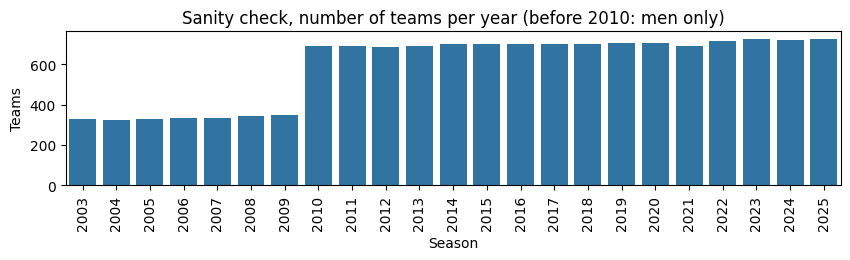

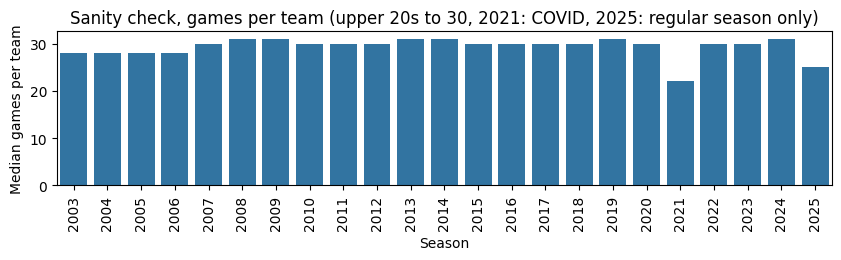

In [5]:
def from_WL_to_od(from_prefix, to_suffix):
    df = detailed_results[[c for c in detailed_results if c[0] == from_prefix]]
    return df.rename(columns={c: f"{c[1:]}_{to_suffix}" for c in df})


def calculate_possessions(df, prefix="", suffix=""):
    df["Poss_o"] = (
        df[f"{prefix}FGA_o{suffix}"]
        - df[f"{prefix}OR_o{suffix}"]
        + df[f"{prefix}TO_o{suffix}"]
        + 0.44 * df[f"{prefix}FTA_o{suffix}"]
    ).astype("float32")
    df["Poss_d"] = (
        df[f"{prefix}FGA_d{suffix}"]
        - df[f"{prefix}OR_d{suffix}"]
        + df[f"{prefix}TO_d{suffix}"]
        + 0.44 * df[f"{prefix}FTA_d{suffix}"]
    ).astype("float32")
    return df


game_team = pd.concat(
    [
        pd.concat(
            [
                from_WL_to_od("W", "o"),
                from_WL_to_od("L", "d"),
                detailed_results["LTeamID"].rename("Opponent"),
            ],
            axis=1,
        ),
        pd.concat(
            [
                from_WL_to_od("L", "o"),
                from_WL_to_od("W", "d"),
                detailed_results["WTeamID"].rename("Opponent"),
            ],
            axis=1,
        ),
    ]
).reset_index(drop=True)

game_team = game_team.rename(columns={"Season_o": "Season", "TeamID_o": "TeamID"})
game_team = game_team.drop(columns=["Season_d", "TeamID_d"])
game_team = calculate_possessions(game_team)

game_team = game_team[
    ["Season", "TeamID", "Opponent"]
    + [c for c in game_team if c[-2:] == "_o"]
    + [c for c in game_team if c[-2:] == "_d"]
]

p(game_team)

if is_notebook:
    sns.barplot(
        game_team.groupby("Season")["TeamID"].nunique().reset_index(name="Teams"),
        x="Season",
        y="Teams",
    )

    plt.title("Sanity check, number of teams per year (before 2010: men only)")
    plt.xticks(rotation=90)
    plt.figure()

    sns.barplot(
        game_team.groupby(["Season", "TeamID"])["Score_o"]
        .count()
        .reset_index()
        .groupby("Season")["Score_o"]
        .median()
        .reset_index(name="Median games per team"),
        x="Season",
        y="Median games per team",
    )

    plt.title(
        "Sanity check, games per team (upper 20s to 30, 2021: COVID, 2025: regular season only)"
    )
    plt.xticks(rotation=90);

In [6]:
season_sum = (
    game_team.drop(columns="Opponent")
    .groupby(["Season", "TeamID"])
    .agg(
        dict(
            Score_o=["count", "sum"],
            **{c: "sum" for c in game_team if c[-2] == "_" and c != "Score_o"}
        )
    )
)

season_sum.columns = season_sum.columns.map("_".join)
season_sum = season_sum.reset_index()
season_sum = season_sum.rename(columns={"Score_o_count": "Games"})
p(season_sum)

,Season,TeamID,Games,Score_o_sum,FGM_o_sum,FGA_o_sum,FGM3_o_sum,FGA3_o_sum,FTM_o_sum,FTA_o_sum,OR_o_sum,DR_o_sum,Ast_o_sum,TO_o_sum,Stl_o_sum,Blk_o_sum,PF_o_sum,Poss_o_sum,Score_d_sum,FGM_d_sum,FGA_d_sum,FGM3_d_sum,FGA3_d_sum,FTM_d_sum,FTA_d_sum,OR_d_sum,DR_d_sum,Ast_d_sum,TO_d_sum,Stl_d_sum,Blk_d_sum,PF_d_sum,Poss_d_sum
0,2003,1102,28,1603,536,1114,219,583,312,479,117,471,364,320,167,50,525,1527.760010,1596,540,1188,133,348,383,539,269,564,256,363,152,44,514,1519.160034
1,2003,1103,27,2127,733,1508,147,434,514,698,264,538,411,341,196,63,536,1892.119995,2110,750,1539,180,496,430,598,325,595,418,414,173,77,606,1891.119995
2,2003,1104,29,2002,695,1653,183,568,429,602,389,690,352,380,187,112,526,1908.880005,1887,670,1603,185,554,362,506,318,656,342,396,156,91,556,1903.640015
3,2003,1105,26,1866,634,1602,197,540,401,568,351,601,378,485,242,54,526,1985.920044,1993,702,1533,163,456,426,637,343,686,411,489,244,109,496,1959.280029
4,2003,1106,28,1781,656,1548,171,494,298,461,344,668,327,477,234,88,509,1883.839966,1785,608,1495,134,426,435,615,317,626,330,422,246,89,452,1870.599976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13578,2025,3476,23,1463,550,1348,162,490,201,252,208,545,377,377,105,62,342,1627.880005,1561,588,1379,153,460,232,330,206,506,299,305,219,76,356,1623.199951
13579,2025,3477,22,1363,502,1335,149,471,210,287,161,497,285,334,140,67,379,1634.280029,1601,604,1385,133,418,260,392,241,607,318,304,173,67,301,1620.479980
13580,2025,3478,24,1254,418,1221,152,502,266,352,165,527,238,413,119,42,348,1623.880005,1716,646,1460,205,589,219,296,229,578,421,283,204,56,384,1644.239990
13581,2025,3479,21,1310,451,1111,141,441,267,366,107,481,215,372,118,29,388,1537.040039,1465,552,1251,103,352,258,378,183,513,262,317,187,55,401,1551.320068


,Season,TeamID,Score_pg_o,Score_poss_o,FGM_pg_o,FGM_poss_o,FGA_pg_o,FGA_poss_o,FGM3_pg_o,FGM3_poss_o,FGA3_pg_o,FGA3_poss_o,FTM_pg_o,FTM_poss_o,FTA_pg_o,FTA_poss_o,OR_pg_o,OR_poss_o,DR_pg_o,DR_poss_o,Ast_pg_o,Ast_poss_o,TO_pg_o,TO_poss_o,Stl_pg_o,Stl_poss_o,Blk_pg_o,Blk_poss_o,PF_pg_o,PF_poss_o,Poss_pg_o,Score_pg_d,Score_poss_d,FGM_pg_d,FGM_poss_d,FGA_pg_d,FGA_poss_d,FGM3_pg_d,FGM3_poss_d,FGA3_pg_d,FGA3_poss_d,FTM_pg_d,FTM_poss_d,FTA_pg_d,FTA_poss_d,OR_pg_d,OR_poss_d,DR_pg_d,DR_poss_d,Ast_pg_d,Ast_poss_d,TO_pg_d,TO_poss_d,Stl_pg_d,Stl_poss_d,Blk_pg_d,Blk_poss_d,PF_pg_d,PF_poss_d,Poss_pg_d,FGPct_o,FGPct3_o,FTPct_o,AstPct_o,AstTO_o,FGPct_d,FGPct3_d,FTPct_d,AstPct_d,AstTO_d,Score_pg_diff,Score_poss_diff,FGM_pg_diff,FGM_poss_diff,FGA_pg_diff,FGA_poss_diff,FGM3_pg_diff,FGM3_poss_diff,FGA3_pg_diff,FGA3_poss_diff,FTM_pg_diff,FTM_poss_diff,FTA_pg_diff,FTA_poss_diff,OR_pg_diff,OR_poss_diff,DR_pg_diff,DR_poss_diff,Ast_pg_diff,Ast_poss_diff,TO_pg_diff,TO_poss_diff,Stl_pg_diff,Stl_poss_diff,Blk_pg_diff,Blk_poss_diff,PF_pg_diff,PF_poss_diff,Poss_pg_diff,FGPct_diff,FGPct3_diff,FTPct_diff,AstPct_diff,AstTO_diff
0,2003,1102,57.250000,1.049249,19.142857,0.350840,39.785713,0.729172,7.821429,0.143347,20.821428,0.381604,11.142858,0.204221,17.107143,0.313531,4.178571,0.076583,16.821428,0.308295,13.000000,0.238257,11.428572,0.209457,5.964286,0.109310,1.785714,0.032728,18.750000,0.343640,54.562859,57.000000,1.050581,19.285715,0.355460,42.428570,0.782011,4.750000,0.087548,12.428572,0.229074,13.678572,0.252113,19.250000,0.354801,9.607142,0.177072,20.142857,0.371258,9.142858,0.168514,12.964286,0.238948,5.428571,0.100055,1.571429,0.028963,18.357143,0.338345,54.255714,0.481149,0.375643,0.651357,0.679105,1.137500,0.454545,0.382184,0.710575,0.474074,0.705234,0.250000,-0.001332,-0.142859,-0.004619,-2.642857,-0.052839,3.071429,0.055799,8.392857,0.152530,-2.535714,-0.047892,-2.142857,-0.041270,-5.428571,-0.100489,-3.321428,-0.062963,3.857142,0.069743,-1.535714,-0.029491,0.535715,0.009255,0.214286,0.003764,0.392857,0.005295,0.307144,0.026604,-0.006541,-0.059218,0.205030,0.432266
1,2003,1103,78.777779,1.124136,27.148148,0.387396,55.851852,0.796990,5.444445,0.077691,16.074074,0.229372,19.037037,0.271653,25.851852,0.368898,9.777778,0.139526,19.925926,0.284337,15.222222,0.217217,12.629630,0.180221,7.259259,0.103588,2.333333,0.033296,19.851852,0.283280,70.078522,78.148148,1.115741,27.777779,0.396590,57.000000,0.813803,6.666667,0.095182,18.370371,0.262278,15.925926,0.227378,22.148148,0.316215,12.037037,0.171856,22.037037,0.314628,15.481482,0.221033,15.333333,0.218918,6.407407,0.091480,2.851852,0.040717,22.444445,0.320445,70.041481,0.486074,0.338710,0.736390,0.560709,1.205279,0.487329,0.362903,0.719064,0.557333,1.009662,0.629631,0.008395,-0.629631,-0.009194,-1.148148,-0.016814,-1.222222,-0.017491,-2.296297,-0.032906,3.111111,0.044274,3.703705,0.052684,-2.259259,-0.032330,-2.111111,-0.030291,-0.259259,-0.003816,-2.703703,-0.038697,0.851852,0.012107,-0.518519,-0.007421,-2.592592,-0.037165,0.037041,-0.001255,-0.024194,0.017326,0.003376,0.195617
2,2003,1104,69.034485,1.048783,23.965517,0.364088,57.000000,0.865953,6.310345,0.095868,19.586206,0.297557,14.793103,0.224739,20.758621,0.315368,13.413794,0.203784,23.793104,0.361468,12.137931,0.184401,13.103448,0.199070,6.448276,0.097963,3.862069,0.058673,18.137932,0.275554,65.823448,65.068962,0.991259,23.103449,0.351957,55.275864,0.842071,6.379310,0.097182,19.103449,0.291021,12.482759,0.190162,17.448277,0.265807,10.965517,0.167048,22.620689,0.344603,11.793103,0.179656,13.655172,0.208023,5.379310,0.081948,3.137931,0.047803,19.172413,0.292072,65.642761,0.420448,0.322183,0.712625,0.506475,0.926316,0.417966,0.333935,0.715415,0.510448,0.863636,3.965523,0.057524,0.862068,0.012131,1.724136,0.023882,-0.068965,-0.001315,0.482758,0.006535,2.310345,0.034577,3.310345,0.049562,2.448277,0.036736,1.172415,0.016866,0.344828,0.004745,-0.551724,-0.008953,1.068966,0.016015,0.724138,0.010870,-1.034481,-0.016518,0.180687,0.002481,-0.011752,-0.002790,

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13583 entries, 0 to 13582
Columns: 104 entries, Season to AstTO_diff
dtypes: float32(102), int32(2)
memory usage: 5.4 MB



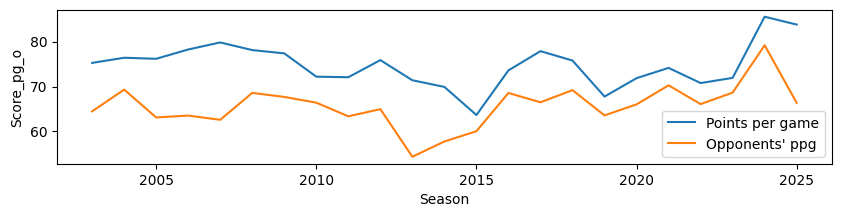

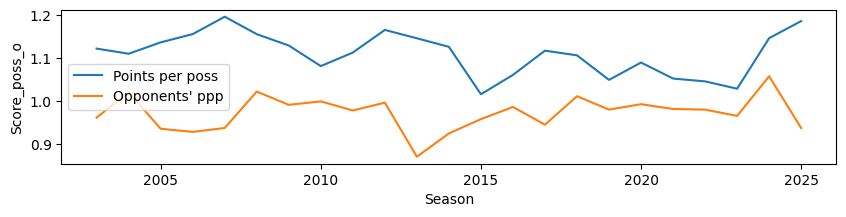

In [7]:
def from_sum_to_pct(sum_df, prefix=""):
    pct_df = sum_df.copy()

    for c in pct_df:
        if c.endswith("_sum"):
            pct_df[f"{c[:-6]}_pg_{c[-5:-4]}"] = (pct_df[c] / pct_df["Games"]).astype(
                "float32"
            )
            if "_o_" in c:
                pct_df[f"{c[:-6]}_poss_{c[-5:-4]}"] = (
                    pct_df[c] / pct_df[f"{prefix}Poss_o_sum"]
                ).astype("float32")
            if "_d_" in c:
                pct_df[f"{c[:-6]}_poss_{c[-5:-4]}"] = (
                    pct_df[c] / pct_df[f"{prefix}Poss_d_sum"]
                ).astype("float32")

    for side in ["o", "d"]:
        pct_df[f"{prefix}FGPct_{side}"] = (
            pct_df[f"{prefix}FGM_{side}_sum"] / pct_df[f"{prefix}FGA_{side}_sum"]
        ).astype("float32")
        pct_df[f"{prefix}FGPct3_{side}"] = (
            pct_df[f"{prefix}FGM3_{side}_sum"] / pct_df[f"{prefix}FGA3_{side}_sum"]
        ).astype("float32")
        pct_df[f"{prefix}FTPct_{side}"] = (
            pct_df[f"{prefix}FTM_{side}_sum"] / pct_df[f"{prefix}FTA_{side}_sum"]
        ).astype("float32")
        pct_df[f"{prefix}AstPct_{side}"] = (
            pct_df[f"{prefix}Ast_{side}_sum"] / pct_df[f"{prefix}FGM_{side}_sum"]
        ).astype("float32")
        pct_df[f"{prefix}AstTO_{side}"] = (
            pct_df[f"{prefix}Ast_{side}_sum"] / pct_df[f"{prefix}TO_{side}_sum"]
        ).astype("float32")

    pct_df = pct_df.drop(columns=[c for c in pct_df if c.endswith("_sum")])
    pct_df = pct_df.drop(
        columns=["Games", f"{prefix}Poss_poss_o", f"{prefix}Poss_poss_d"]
    )

    for c in pct_df:
        if c.endswith("_o"):
            pct_df[f"{c[:-2]}_diff"] = pct_df[c] - pct_df[f"{c[:-2]}_d"]

    return pct_df


season_team = from_sum_to_pct(season_sum)
p(season_team)
season_team.info()
print()

if is_notebook:
    sns.lineplot(
        season_team[season_team["TeamID"] == 1196],
        x="Season",
        y="Score_pg_o",
        label="Points per game",
    )
    sns.lineplot(
        season_team[season_team["TeamID"] == 1196],
        x="Season",
        y="Score_pg_d",
        label="Opponents' ppg",
    )
    plt.figure()
    sns.lineplot(
        season_team[season_team["TeamID"] == 1196],
        x="Season",
        y="Score_poss_o",
        label="Points per poss",
    )
    sns.lineplot(
        season_team[season_team["TeamID"] == 1196],
        x="Season",
        y="Score_poss_d",
        label="Opponents' ppp",
    );

The season stats (simple sums and possessions) for each opponent of TeamID (multiple rows for multiple matchups throughout the season)


,Season,TeamID,Opponent,Games,sos_Score_o_sum,sos_FGM_o_sum,sos_FGA_o_sum,sos_FGM3_o_sum,sos_FGA3_o_sum,sos_FTM_o_sum,sos_FTA_o_sum,sos_OR_o_sum,sos_DR_o_sum,sos_Ast_o_sum,sos_TO_o_sum,sos_Stl_o_sum,sos_Blk_o_sum,sos_PF_o_sum,sos_Poss_o_sum,sos_Score_d_sum,sos_FGM_d_sum,sos_FGA_d_sum,sos_FGM3_d_sum,sos_FGA3_d_sum,sos_FTM_d_sum,sos_FTA_d_sum,sos_OR_d_sum,sos_DR_d_sum,sos_Ast_d_sum,sos_TO_d_sum,sos_Stl_d_sum,sos_Blk_d_sum,sos_PF_d_sum,sos_Poss_d_sum
0,2003,1421,1411,31,2268,771,1725,190,586,536,873,412,772,442,472,198,67,571,2169.119873,2217,802,1881,237,724,376,588,372,716,430,442,245,81,671,2209.719971
1,2003,1112,1436,30,2017,740,1684,157,465,380,574,384,772,424,425,209,89,476,1977.560059,1911,691,1663,212,645,317,471,289,670,407,393,216,113,528,1974.239990
2,2003,1113,1272,30,2232,787,1809,210,610,448,685,428,775,493,412,216,152,562,2094.399902,1993,706,1737,177,545,404,623,368,711,404,446,218,96,597,2089.119873
3,2003,1141,1166,34,2688,974,1956,270,693,470,678,373,782,575,462,283,153,591,2343.320068,2202,817,1879,164,479,404,576,376,725,423,581,222,86,659,2337.439941
4,2003,1143,1301,31,2246,755,1656,248,696,488,634,302,687,456,440,238,100,579,2072.959961,2116,730,1658,179,530,477,659,334,663,394,452,231,87,594,2065.959961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401295,2025,3416,3242,26,1736,587,1376,172,489,390,521,150,597,303,359,190,66,450,1814.239990,1733,627,1492,191,556,288,425,220,614,371,367,167,79,508,1826.000000
401296,2025,3428,3329,26,2029,742,1605,216,615,329,472,263,682,372,382,220,101,437,1931.679932,1536,555,1530,147,548,279,394,200,535,272,416,172,86,470,1919.359985
401297,2025,3194,3349,26,1726,651,1581,166,524,258,363,239,702,377,401,178,88,446,1902.719971,1642,599,1548,142,470,302,438,215,600,287,360,190,84,411,1885.719971
401298,2025,3150,3378,27,1787,678,1610,145,421,286,409,287,605,400,359,230,90,440,1861.959961,1624,606,1488,146,467,266,394,222,598,324,427,154,67,453,1866.359985


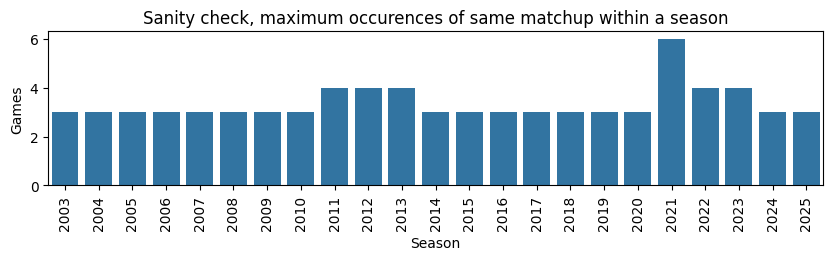

,Season,Team_1,Team_2,Games
0,2021,Boston Univ,Holy Cross,6
1,2021,Lafayette,Loyola MD,6


In [8]:
game_sos = pd.merge(
    game_team[["Season", "TeamID", "Opponent"]],
    season_sum,
    left_on=["Season", "Opponent"],
    right_on=["Season", "TeamID"],
    suffixes=["", "_"],
)

game_sos = game_sos.drop(columns=["TeamID_"])
game_sos = game_sos.rename(
    columns={c: f"sos_{c}" for c in game_sos if c[-4:] == "_sum"}
)

print(
    "The season stats (simple sums and possessions) for each opponent of TeamID (multiple rows for multiple matchups throughout the season)"
)
p(game_sos)

if is_notebook:
    df = (
        game_sos.groupby(["Season", "TeamID", "Opponent"])["Games"]
        .count()
        .reset_index()
    )
    sns.barplot(
        df.groupby("Season")["Games"].max().reset_index(),
        x="Season",
        y="Games",
    )
    plt.title("Sanity check, maximum occurences of same matchup within a season")
    plt.xticks(rotation=90)
    plt.show()
    df = df[df["Games"] == 6]
    df = df[df["TeamID"] < df["Opponent"]].reset_index(drop=True)
    mteams = pd.read_csv(f"{data_dir}/Mteams.csv")
    df["Team_1"] = pd.merge(df, mteams, left_on="TeamID", right_on="TeamID")["TeamName"]
    df["Team_2"] = pd.merge(df, mteams, left_on="Opponent", right_on="TeamID")[
        "TeamName"
    ]
    p(df[["Season", "Team_1", "Team_2", "Games"]])

[goterriers opponent history](https://goterriers.com/sports/mens-basketball/opponent-history/holy-cross/102)

```
1 1/ 4/2021 W 83-76
2 1/ 5/2021 L 66-68
3 2/13/2021 L 65-82
4 2/14/2021 W 86-68
5 2/17/2021 W 78-69
6 2/24/2021 L 75-86
```

In [9]:
sum_sos = (
    game_sos.drop(columns="Opponent")
    .groupby(["Season", "TeamID"], as_index=False)
    .sum()
)
p(sum_sos[(sum_sos["Season"] > 2021) & (sum_sos["TeamID"] == 1196)])

,Season,TeamID,Games,sos_Score_o_sum,sos_FGM_o_sum,sos_FGA_o_sum,sos_FGM3_o_sum,sos_FGA3_o_sum,sos_FTM_o_sum,sos_FTA_o_sum,sos_OR_o_sum,sos_DR_o_sum,sos_Ast_o_sum,sos_TO_o_sum,sos_Stl_o_sum,sos_Blk_o_sum,sos_PF_o_sum,sos_Poss_o_sum,sos_Score_d_sum,sos_FGM_d_sum,sos_FGA_d_sum,sos_FGM3_d_sum,sos_FGA3_d_sum,sos_FTM_d_sum,sos_FTA_d_sum,sos_OR_d_sum,sos_DR_d_sum,sos_Ast_d_sum,sos_TO_d_sum,sos_Stl_d_sum,sos_Blk_d_sum,sos_PF_d_sum,sos_Poss_d_sum
10786,2022,1196,1032,73001,26050,59766,7126,22014,13775,19124,9377,24380,13515,12991,7384,4009,17473,71794.562500,71069,25186,59364,7347,22619,13350,18566,8872,23505,13296,13146,7254,3597,17639,71807.039062
11500,2023,1196,1075,77083,27152,61891,7823,23283,14956,20788,10269,25048,14549,12743,7160,3584,18288,73511.718750,74207,26252,61454,7528,23099,14175,19860,9267,23717,13445,12637,7012,3320,18734,73562.398438
12224,2024,1196,1202,91486,31936,71389,9429,27346,18185,24809,10975,28211,16306,13006,8323,4760,20663,84335.960938,87886,30752,71072,8907,26884,17475,23971,10841,27454,15536,13621,7792,4446,21274,84399.242188
12946,2025,1196,658,49347,17306,38231,5151,15090,9584,13236,5815,15343,9149,7359,4628,2710,10988,45598.839844,47201,16659,38775,5010,15221,8873,12282,5888,14615,8395,7504,4509,2250,11381,45795.082031


In [10]:
season_sos = from_sum_to_pct(sum_sos, prefix="sos_")
p(season_sos[(sum_sos["Season"] > 2021) & (season_sos["TeamID"] == 1196)])

,Season,TeamID,sos_Score_pg_o,sos_Score_poss_o,sos_FGM_pg_o,sos_FGM_poss_o,sos_FGA_pg_o,sos_FGA_poss_o,sos_FGM3_pg_o,sos_FGM3_poss_o,sos_FGA3_pg_o,sos_FGA3_poss_o,sos_FTM_pg_o,sos_FTM_poss_o,sos_FTA_pg_o,sos_FTA_poss_o,sos_OR_pg_o,sos_OR_poss_o,sos_DR_pg_o,sos_DR_poss_o,sos_Ast_pg_o,sos_Ast_poss_o,sos_TO_pg_o,sos_TO_poss_o,sos_Stl_pg_o,sos_Stl_poss_o,sos_Blk_pg_o,sos_Blk_poss_o,sos_PF_pg_o,sos_PF_poss_o,sos_Poss_pg_o,sos_Score_pg_d,sos_Score_poss_d,sos_FGM_pg_d,sos_FGM_poss_d,sos_FGA_pg_d,sos_FGA_poss_d,sos_FGM3_pg_d,sos_FGM3_poss_d,sos_FGA3_pg_d,sos_FGA3_poss_d,sos_FTM_pg_d,sos_FTM_poss_d,sos_FTA_pg_d,sos_FTA_poss_d,sos_OR_pg_d,sos_OR_poss_d,sos_DR_pg_d,sos_DR_poss_d,sos_Ast_pg_d,sos_Ast_poss_d,sos_TO_pg_d,sos_TO_poss_d,sos_Stl_pg_d,sos_Stl_poss_d,sos_Blk_pg_d,sos_Blk_poss_d,sos_PF_pg_d,sos_PF_poss_d,sos_Poss_pg_d,sos_FGPct_o,sos_FGPct3_o,sos_FTPct_o,sos_AstPct_o,sos_AstTO_o,sos_FGPct_d,sos_FGPct3_d,sos_FTPct_d,sos_AstPct_d,sos_AstTO_d,sos_Score_pg_diff,sos_Score_poss_diff,sos_FGM_pg_diff,sos_FGM_poss_diff,sos_FGA_pg_diff,sos_FGA_poss_diff,sos_FGM3_pg_diff,sos_FGM3_poss_diff,sos_FGA3_pg_diff,sos_FGA3_poss_diff,sos_FTM_pg_diff,sos_FTM_poss_diff,sos_FTA_pg_diff,sos_FTA_poss_diff,sos_OR_pg_diff,sos_OR_poss_diff,sos_DR_pg_diff,sos_DR_poss_diff,sos_Ast_pg_diff,sos_Ast_poss_diff,sos_TO_pg_diff,sos_TO_poss_diff,sos_Stl_pg_diff,sos_Stl_poss_diff,sos_Blk_pg_diff,sos_Blk_poss_diff,sos_PF_pg_diff,sos_PF_poss_diff,sos_Poss_pg_diff,sos_FGPct_diff,sos_FGPct3_diff,sos_FTPct_diff,sos_AstPct_diff,sos_AstTO_diff
10786,2022,1196,70.737404,1.016804,25.242249,0.362841,57.912792,0.832459,6.905039,0.099255,21.331396,0.306625,13.347868,0.191867,18.531008,0.266371,9.086241,0.130609,23.624031,0.339580,13.095930,0.188245,12.588179,0.180947,7.155039,0.102849,3.884690,0.055840,16.931202,0.243375,69.568375,68.865311,0.989722,24.405039,0.350746,57.523254,0.826716,7.119186,0.102316,21.917635,0.314997,12.936047,0.185915,17.990311,0.258554,8.596899,0.123553,22.776163,0.327336,12.883721,0.185163,12.738372,0.183074,7.029070,0.101021,3.485465,0.050093,17.092054,0.245644,69.580467,0.435867,0.323703,0.720299,0.518810,1.040336,0.424264,0.324815,0.719056,0.527912,1.011410,1.872093,0.027082,0.837210,0.012095,0.389538,0.005743,-0.214147,-0.003060,-0.586239,-0.008372,0.411821,0.005952,0.540697,0.007817,0.489342,0.007055,0.847868,0.012244,0.212209,0.003083,-0.150193,-0.002127,0.125969,0.001828,0.399225,0.005747,-0.160852,-0.002269,-0.012093,0.011603,-0.001112,0.001243,-0.009102,0.028925
11500,2023,1196,71.705116,1.048581,25.257675,0.369356,57.573025,0.841920,7.277209,0.106418,21.658606,0.316725,13.912559,0.203451,19.337675,0.282785,9.552558,0.139692,23.300465,0.340735,13.533954,0.197914,11.853953,0.173347,6.660465,0.097399,3.333953,0.048754,17.012093,0.248777,68.382996,69.029770,1.008763,24.420465,0.356867,57.166512,0.835400,7.002791,0.102335,21.487442,0.314006,13.186047,0.192694,18.474419,0.269975,8.620465,0.125975,22.062326,0.322407,12.506977,0.182770,11.755349,0.171786,6.522791,0.095320,3.088372,0.045132,17.426977,0.254668,68.430138,0.438707,0.335996,0.719454,0.535835,1.141725,0.427181,0.325902,0.713746,0.512151,1.063939,2.675346,0.039819,0.837210,0.012489,0.406513,0.006521,0.274418,0.004084,0.171164,0.002719,0.726512,0.010757,0.863256,0.012810,0.932093,0.013717,1.238138,0.018328,1.026977,0.015144,0.098604,0.001560,0.137674,0.002079,0.245581,0.003622,-0.414885,-0.005891,-0.047142,0.011525,0.010095,0.005707,0.023684,0.077786
12224,2024,1196,76.111481,1.084780,26.569052,0.378676,59.391846,0.846484,7.844426,0.111803,22.750416,0.324251,15.128952,0.215626,20.639767,0.294169,9.130615,0.130134,23.470051,0.334507,13.565723,0.193346,10.820299,0.154217,6.924293,0.098689,3.960067,0.056441,17.190516,0.245008,70.163033,73.116470,1.041313,25.584026,0.364363,59.128120,0.842093,7.410150,0.105534,22.366056,0.318534,14.538270,0.207052,19.942596,0.284019,9.019135,0.128449,22.840265,0.325287,12.925125,0.184077,11.331946,0.161388,6.482529,0.092323,3.698835,0.052678,17.698835,0.252064,70.

In [11]:
season = pd.merge(season_team, season_sos, on=["Season", "TeamID"])
p(season)

,Season,TeamID,Score_pg_o,Score_poss_o,FGM_pg_o,FGM_poss_o,FGA_pg_o,FGA_poss_o,FGM3_pg_o,FGM3_poss_o,FGA3_pg_o,FGA3_poss_o,FTM_pg_o,FTM_poss_o,FTA_pg_o,FTA_poss_o,OR_pg_o,OR_poss_o,DR_pg_o,DR_poss_o,Ast_pg_o,Ast_poss_o,TO_pg_o,TO_poss_o,Stl_pg_o,Stl_poss_o,Blk_pg_o,Blk_poss_o,PF_pg_o,PF_poss_o,Poss_pg_o,Score_pg_d,Score_poss_d,FGM_pg_d,FGM_poss_d,FGA_pg_d,FGA_poss_d,FGM3_pg_d,FGM3_poss_d,FGA3_pg_d,FGA3_poss_d,FTM_pg_d,FTM_poss_d,FTA_pg_d,FTA_poss_d,OR_pg_d,OR_poss_d,DR_pg_d,DR_poss_d,Ast_pg_d,Ast_poss_d,TO_pg_d,TO_poss_d,Stl_pg_d,Stl_poss_d,Blk_pg_d,Blk_poss_d,PF_pg_d,PF_poss_d,Poss_pg_d,FGPct_o,FGPct3_o,FTPct_o,AstPct_o,AstTO_o,FGPct_d,FGPct3_d,FTPct_d,AstPct_d,AstTO_d,Score_pg_diff,Score_poss_diff,FGM_pg_diff,FGM_poss_diff,FGA_pg_diff,FGA_poss_diff,FGM3_pg_diff,FGM3_poss_diff,FGA3_pg_diff,FGA3_poss_diff,FTM_pg_diff,FTM_poss_diff,FTA_pg_diff,FTA_poss_diff,OR_pg_diff,OR_poss_diff,DR_pg_diff,DR_poss_diff,Ast_pg_diff,Ast_poss_diff,TO_pg_diff,TO_poss_diff,Stl_pg_diff,Stl_poss_diff,Blk_pg_diff,Blk_poss_diff,PF_pg_diff,PF_poss_diff,Poss_pg_diff,FGPct_diff,FGPct3_diff,FTPct_diff,AstPct_diff,AstTO_diff,sos_Score_pg_o,sos_Score_poss_o,sos_FGM_pg_o,sos_FGM_poss_o,sos_FGA_pg_o,sos_FGA_poss_o,sos_FGM3_pg_o,sos_FGM3_poss_o,sos_FGA3_pg_o,sos_FGA3_poss_o,sos_FTM_pg_o,sos_FTM_poss_o,sos_FTA_pg_o,sos_FTA_poss_o,sos_OR_pg_o,sos_OR_poss_o,sos_DR_pg_o,sos_DR_poss_o,sos_Ast_pg_o,sos_Ast_poss_o,sos_TO_pg_o,sos_TO_poss_o,sos_Stl_pg_o,sos_Stl_poss_o,sos_Blk_pg_o,sos_Blk_poss_o,sos_PF_pg_o,sos_PF_poss_o,sos_Poss_pg_o,sos_Score_pg_d,sos_Score_poss_d,sos_FGM_pg_d,sos_FGM_poss_d,sos_FGA_pg_d,sos_FGA_poss_d,sos_FGM3_pg_d,sos_FGM3_poss_d,sos_FGA3_pg_d,sos_FGA3_poss_d,sos_FTM_pg_d,sos_FTM_poss_d,sos_FTA_pg_d,sos_FTA_poss_d,sos_OR_pg_d,sos_OR_poss_d,sos_DR_pg_d,sos_DR_poss_d,sos_Ast_pg_d,sos_Ast_poss_d,sos_TO_pg_d,sos_TO_poss_d,sos_Stl_pg_d,sos_Stl_poss_d,sos_Blk_pg_d,sos_Blk_poss_d,sos_PF_pg_d,sos_PF_poss_d,sos_Poss_pg_d,sos_FGPct_o,sos_FGPct3_o,sos_FTPct_o,sos_AstPct_o,sos_AstTO_o,sos_FGPct_d,sos_FGPct3_d,sos_FTPct_d,sos_AstPct_d,sos_AstTO_d,sos_Score_pg_diff,sos_Score_poss_diff,sos_FGM_pg_diff,sos_FGM_poss_diff,sos_FGA_pg_diff,sos_FGA_poss_diff,sos_FGM3_pg_diff,sos_FGM3_poss_diff,sos_FGA3_pg_diff,sos_FGA3_poss_diff,sos_FTM_pg_diff,sos_FTM_poss_diff,sos_FTA_pg_diff,sos_FTA_poss_diff,sos_OR_pg_diff,sos_OR_poss_diff,sos_DR_pg_diff,sos_DR_poss_diff,sos_Ast_pg_diff,sos_Ast_poss_diff,sos_TO_pg_diff,sos_TO_poss_diff,sos_Stl_pg_diff,sos_Stl_poss_diff,sos_Blk_pg_diff,sos_Blk_poss_diff,sos_PF_pg_diff,sos_PF_poss_diff,sos_Poss_pg_diff,sos_FGPct_diff,sos_FGPct3_diff,sos_FTPct_diff,sos_AstPct_diff,sos_AstTO_diff
0,2003,1102,57.250000,1.049249,19.142857,0.350840,39.785713,0.729172,7.821429,0.143347,20.821428,0.381604,11.142858,0.204221,17.107143,0.313531,4.178571,0.076583,16.821428,0.308295,13.000000,0.238257,11.428572,0.209457,5.964286,0.109310,1.785714,0.032728,18.750000,0.343640,54.562859,57.000000,1.050581,19.285715,0.355460,42.428570,0.782011,4.750000,0.087548,12.428572,0.229074,13.678572,0.252113,19.250000,0.354801,9.607142,0.177072,20.142857,0.371258,9.142858,0.168514,12.964286,0.238948,5.428571,0.100055,1.571429,0.028963,18.357143,0.338345,54.255714,0.481149,0.375643,0.651357,0.679105,1.137500,0.454545,0.382184,0.710575,0.474074,0.705234,0.250000,-0.001332,-0.142859,-0.004619,-2.642857,-0.052839,3.071429,0.055799,8.392857,0.152530,-2.535714,-0.047892,-2.142857,-0.041270,-5.428571,-0.100489,-3.321428,-0.062963,3.857142,0.069743,-1.535714,-0.029491,0.535715,0.009255,0.214286,0.003764,0.392857,0.005295,0.307144,0.026604,-0.006541,-0.059218,0.205030,0.432266,71.142502,1.044032,24.835192,0.364462,55.365551,0.812502,6.151177,0.090270,17.384138,0.255116,15.320942,0.224838,21.940521,0.321982,11.620818,0.170538,22.885998,0.335857,13.553904,0.198907,14.743494,0.216364,6.992565,0.102617,3.091698,0.045371,20.104090,0.295032,68.142059,70.231720,1.031614,24.311029,0.357098,54.609665,0.802146,6.063197,0.089061,17.374226,0.255205,15.546469,0.228358,22.178438,0.325773,11.14993

In [12]:
train = pd.merge(
    margin, season, left_on=["Season", "TeamID_1"], right_on=["Season", "TeamID"]
)
train = train.drop(columns="TeamID")
train = train.rename(
    columns={c: f"{c}_1" for c in train if c.split("_")[-1] in ("o", "d", "diff")}
)

train = pd.merge(
    train, season, left_on=["Season", "TeamID_2"], right_on=["Season", "TeamID"]
)
train = train.drop(columns="TeamID")
train = train.rename(
    columns={c: f"{c}_2" for c in train if c.split("_")[-1] in ("o", "d", "diff")}
)

train = train.sort_values(["Season", "DayNum", "TeamID_1", "TeamID_2"]).reset_index(
    drop=True
)

# p(train)
train.info()
print()
print(train.select_dtypes("float64").columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200650 entries, 0 to 200649
Columns: 413 entries, Season to sos_AstTO_diff_2
dtypes: float32(409), int32(4)
memory usage: 316.1 MB

Index([], dtype='object')


In [13]:
X_df = train.drop(["Season", "DayNum", "TeamID_1", "TeamID_2", "Margin"], axis=1)

print(X_df.columns)
print()
print(sorted(set(train.columns) - set(X_df.columns)))
print()

X = X_df.values
X = StandardScaler().fit_transform(X)

y = train["Margin"].values.reshape(-1, 1)
y = StandardScaler().fit_transform(y)

print(
    f"{'detailed_results':<16} {detailed_results.shape[0]:>7,} {detailed_results.shape[1]:>3} {detailed_results['WSeason'].min()} {detailed_results['WSeason'].max()}"
)

print(
    f"{'train':<16} {train.shape[0]:>7,} {train.shape[1]:>3} {train['Season'].min()} {train['Season'].max()}"
)

print(f"{'X':<16} {X.shape[0]:>7,} {X.shape[1]:>3}")
print(f"{'y':<16} {y.shape[0]:>7,} {y.shape[1]:>3}")

Index(['Score_pg_o_1', 'Score_poss_o_1', 'FGM_pg_o_1', 'FGM_poss_o_1',
       'FGA_pg_o_1', 'FGA_poss_o_1', 'FGM3_pg_o_1', 'FGM3_poss_o_1',
       'FGA3_pg_o_1', 'FGA3_poss_o_1',
       ...
       'sos_Blk_pg_diff_2', 'sos_Blk_poss_diff_2', 'sos_PF_pg_diff_2',
       'sos_PF_poss_diff_2', 'sos_Poss_pg_diff_2', 'sos_FGPct_diff_2',
       'sos_FGPct3_diff_2', 'sos_FTPct_diff_2', 'sos_AstPct_diff_2',
       'sos_AstTO_diff_2'],
      dtype='object', length=408)

['DayNum', 'Margin', 'Season', 'TeamID_1', 'TeamID_2']

detailed_results 200,650  33 2003 2025
train            200,650 413 2003 2025
X                200,650 408
y                200,650   1


In [15]:
class NetDataset(Dataset):
    def __init__(self, X, y, device="cpu"):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].to(self.device), self.y[idx].to(self.device)


class NetModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(X.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


n_folds = 5
n_epochs_per_fold = 100
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.MSELoss()
criterion = criterion.to(device)

for fold_n, (i_fold, i_oof) in enumerate(kf.split(X)):
    print(f"fold {fold_n+1}/{n_folds}")

    load_fold = DataLoader(
        NetDataset(X[i_fold], y[i_fold], device),
        batch_size=128,
        shuffle=True,
    )

    load_oof = DataLoader(
        NetDataset(X[i_oof], y[i_oof], device),
        batch_size=128,
        shuffle=False,
    )

    m = NetModule()
    m.to(device)
    m.train()
    optim = torch.optim.Adam(m.parameters())
    loss_oof_min = float("inf")

    for epoch_n in range(n_epochs_per_fold):
        print(f"  epoch {epoch_n+1}/{n_epochs_per_fold} ", end="", flush=True)
        loss_epoch = 0.0

        for inputs_fold, targets_fold in load_fold:
            optim.zero_grad()
            outputs_fold = m(inputs_fold)
            loss = criterion(outputs_fold, targets_fold)
            loss.backward()
            optim.step()
            loss_epoch += loss.item()

        print(f"fold={loss_epoch / len(load_fold):.4f} ", end="", flush=True)

        m.eval()
        loss_oof = 0.0

        with torch.no_grad():
            for inputs_oof, targets_oof in load_oof:
                outputs_oof = m(inputs_oof)
                loss = criterion(outputs_oof, targets_oof)
                loss_oof += loss.item()

        loss_oof = loss_oof / len(load_oof)
        print(f"oof={loss_oof:.4f} ", end="", flush=True)
        m.train()

        if loss_oof_min > loss_oof:
            loss_oof_min = loss_oof
            torch.save(m.state_dict(), f"netmodule_{fold_n}.pt")
            print("*", flush=True)
            patience = 0
        else:
            patience += 1
            print(flush=True)
            if patience > 7:
                break

fold 1/5
  epoch 1/100 fold=0.4519 oof=0.4411 *
  epoch 2/100 

KeyboardInterrupt: 